# Adaboost
I will implement AdaBoost from scratch and applied it to a spam dataset, classifying data into spam and not spam. DecisionTreeClassifier from sklearn (with default max_depth=1) can be called as base classifiers.

`
h = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
h.fit(X, Y, sample_weight=w)
`

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [2]:
# accuracy computation
# this data is not highly imbalance so accuracy is ok
def accuracy(y, pred):
    return np.sum(y == pred) / float(len(y)) 

In [3]:
def parse_spambase_data(filename):
    """ Given a filename return X and Y numpy arrays

    X is of size number of rows x num_features
    Y is an array of size the number of rows
    Y is the last element of each row. (Convert 0 to -1)
    """
    import pandas as pd
    df = pd.read_csv(filename, header=None)
    X = df.iloc[:,:-1]
    Y = df.iloc[:,-1]
    Y = [-1 if elem == 0 else elem for elem in Y]
    return X, Y

In [4]:
y_test = np.array([1., -1., 1., 1., -1., -1., 1., 1., 1., -1.])
X, Y = parse_spambase_data("tiny.spam.train")
for i in range(len(y_test)): assert(y_test[i] == Y[i])
n, m = X.shape

In [5]:
def adaboost(X, y, num_iter, max_depth=1):
    """Given an numpy matrix X, a array y and num_iter return trees and weights 
   
    Input: X, y, num_iter
    Outputs: array of trees from DecisionTreeClassifier
             trees_weights array of floats
    Assumes y is {-1, 1}
    """
    trees = []
    trees_weights = [] 
    N, _ = X.shape
    d = np.ones(N) / N
    epsilon = 0.0001

    for j in range(num_iter):
        h = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
        h.fit(X, y, sample_weight=d)
        trees.append(h)
        pred = h.predict(X)
        error = [1 if y[i] != pred[i] else 0 for i in range(len(y))]
        err = np.sum(np.multiply(d, error))/np.sum(d)
        if err < epsilon: err = epsilon
        alpha = np.log((1-err)/err)
        trees_weights.append(alpha)
        d = [d[i]*np.exp(alpha*error[i]) for i in range(len(d))]
    return trees, trees_weights

In [6]:
X, Y = parse_spambase_data("tiny.spam.train")
trees, weights = adaboost(X, Y, 2)
y_hat_0 = trees[0].predict(X)

In [7]:
def adaboost_predict(X, trees, trees_weights):
    """Given X, trees and weights predict Y
    """
    # X input, y output
    N, _ =  X.shape
    y = np.zeros(N)
    for i in range(N):
        y_hat = np.sum(np.multiply(trees_weights, [tree.predict(X)[i] for tree in trees]))
        if y_hat > 0: y[i] = 1
        else: y[i] = -1
    return y

In [8]:
x = np.array([[0, -1], [1, 0], [-1, 0]])
y = np.array([-1, 1, 1])
trees, weights = adaboost(x, y, 1)
pred = adaboost_predict(x, trees, weights)

In [9]:
X, Y = parse_spambase_data("spambase.train")
X_test, Y_test = parse_spambase_data("spambase.test")
trees, trees_weights = adaboost(X, Y, 10)
Yhat = adaboost_predict(X, trees, trees_weights)
Yhat_test = adaboost_predict(X_test, trees, trees_weights)
    
acc_test = accuracy(Y_test, Yhat_test)
acc_train = accuracy(Y, Yhat)
print("Train Accuracy %.4f" % acc_train)
print("Test Accuracy %.4f" % acc_test)

Train Accuracy 0.9111
Test Accuracy 0.9190


# Gradient boosting for regression with MSE loss
Then I will implement a version of gradient boosting from scratch and applied it to predict rental prices. DecisionTreeRegressor from sklearn can be called as base classifiers.
 
`tree = DecisionTreeRegressor(max_depth=max_depth, random_state=0)`

In [12]:
def load_dataset():
    dataset = np.loadtxt("rent-ideal.csv", delimiter=",", skiprows=1)
    y = dataset[:, -1]
    X = dataset[:, 0:- 1]
    return X, y

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


def gradient_boosting_mse(X, y, num_iter, max_depth=1, nu=0.1):
    """Given X, a array y and num_iter return y_mean and trees 
   
    Input: X, y, num_iter
           max_depth
           nu (is the shinkage)
    Outputs:y_mean, array of trees from DecisionTreeRegression
    """
    trees = []
    N, _ = X.shape
    y_mean = np.mean(y)
    fm = y_mean
    
    for i in range(num_iter):
        resid = y - fm
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=0)
        tree.fit(X, resid)
        trees.append(tree)
        fm = fm + nu * tree.predict(X)
    return y_mean, trees

In [14]:
def gradient_boosting_predict(X, trees, y_mean,  nu=0.1):
    """Given X, trees, y_mean predict y_hat
    """
    y_hat = y_mean
    for tree in trees:
        y_hat = y_hat + nu * tree.predict(X)
    return y_hat

In [15]:
X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=3)

y_mean, trees = gradient_boosting_mse(X_train, y_train, 300, max_depth=7, nu=0.1)
y_hat_train = gradient_boosting_predict(X_train, trees, y_mean, nu=0.1)

In [16]:
y_hat = gradient_boosting_predict(X_val, trees, y_mean, nu=0.1)

## Metric as a function of the number of trees
Fix the Shrinkage to 0.1, find the best value for numTrees and corresponding train and validation R^2.

In [17]:
r2_train = []
r2_val = []
for numTrees in range(500, 3000, 250):
    y_mean, trees = gradient_boosting_mse(X_train, y_train, numTrees, max_depth=7, nu=0.1)
    y_hat_train = gradient_boosting_predict(X_train, trees, y_mean, nu=0.1)
    r2_train.append(np.around(r2_score(y_train, y_hat_train), decimals=4))
    y_hat = gradient_boosting_predict(X_val, trees, y_mean, nu=0.1)
    r2_val.append(np.around(r2_score(y_val, y_hat), decimals=4))

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.xlabel("numTrees")
plt.ylabel("r2")
plt.grid()
plt.plot(range(500,3000,250), r2_train, label="gdb_train")
plt.plot(range(500,3000,250), r2_val, label="gdb_val")
plt.legend(loc="upper left")

When numTrees reach 1500, $r^2$ of validation set does not increase any more. When numTrees > 2000, $r^2$ of validation set starts to decrease. Therefore, the best value of numTrees is 1500.

## Hyper-parameters exploration
Compare results with gradient boosting package (XGBoost). Explore the hyper parameters given in the package.

### min_child_weight = 0

In [19]:
import xgboost as xgb

xgb_pars = {'min_child_weight': 0, 'eta': 0.1, 'colsample_bytree': 1, 'max_depth': 7,
            'subsample': 0.5, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

r2_xgb_train = []
r2_xgb_val = []
for numTrees in range(500,3000,250):
    gbm = xgb.train(xgb_pars, dtrain, numTrees)
    xgb_train = gbm.predict(dtrain)
    xgb_val = gbm.predict(dvalid)
    r2_xgb_train.append(np.around(r2_score(y_train, xgb_train), decimals=4))
    r2_xgb_val.append(np.around(r2_score(y_val, xgb_val), decimals=4))

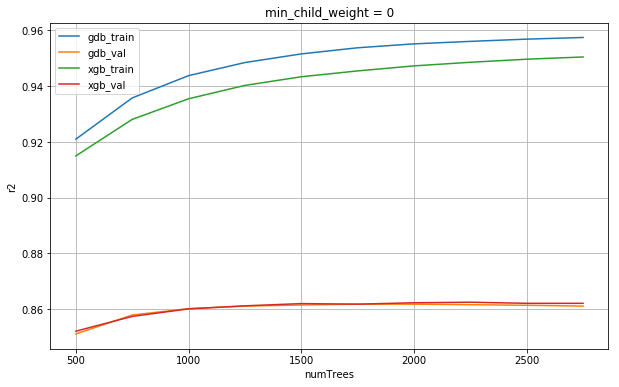

In [20]:
plt.figure(figsize=(10,6))
plt.xlabel("numTrees")
plt.ylabel("r2")
plt.title("min_child_weight = 0")
plt.grid()
plt.plot(range(500,3000,250), r2_train, label="gdb_train")
plt.plot(range(500,3000,250), r2_val, label="gdb_val")
plt.plot(range(500,3000,250), r2_xgb_train, label="xgb_train")
plt.plot(range(500,3000,250), r2_xgb_val, label="xgb_val")
plt.legend(loc="upper left")

### min_child_weight = 5

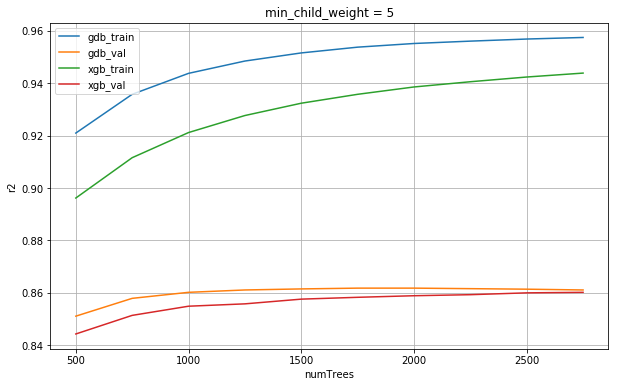

In [21]:
xgb_pars = {'min_child_weight': 5, 'eta': 0.1, 'colsample_bytree': 1, 'max_depth': 7,
            'subsample': 0.5, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

r2_xgb_train = []
r2_xgb_val = []
for numTrees in range(500,3000,250):
    gbm = xgb.train(xgb_pars, dtrain, numTrees)
    xgb_train = gbm.predict(dtrain)
    xgb_val = gbm.predict(dvalid)
    r2_xgb_train.append(np.around(r2_score(y_train, xgb_train), decimals=4))
    r2_xgb_val.append(np.around(r2_score(y_val, xgb_val), decimals=4))
    

plt.figure(figsize=(10,6))
plt.xlabel("numTrees")
plt.ylabel("r2")
plt.title("min_child_weight = 5")
plt.grid()
plt.plot(range(500,3000,250), r2_train, label="gdb_train")
plt.plot(range(500,3000,250), r2_val, label="gdb_val")
plt.plot(range(500,3000,250), r2_xgb_train, label="xgb_train")
plt.plot(range(500,3000,250), r2_xgb_val, label="xgb_val")
plt.legend(loc="upper left")

### min_child_weight = 15

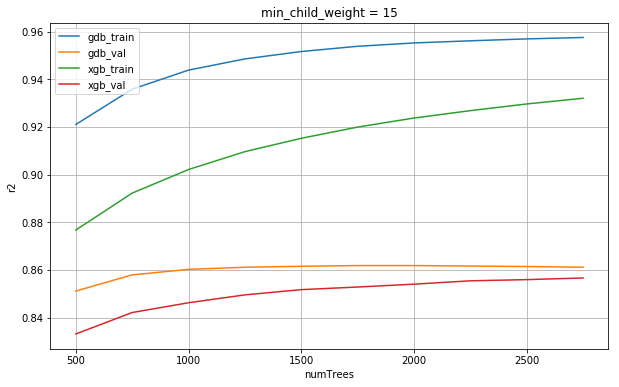

In [22]:
xgb_pars = {'min_child_weight': 15, 'eta': 0.1, 'colsample_bytree': 1, 'max_depth': 7,
            'subsample': 0.5, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

r2_xgb_train = []
r2_xgb_val = []
for numTrees in range(500,3000,250):
    gbm = xgb.train(xgb_pars, dtrain, numTrees)
    xgb_train = gbm.predict(dtrain)
    xgb_val = gbm.predict(dvalid)
    r2_xgb_train.append(np.around(r2_score(y_train, xgb_train), decimals=4))
    r2_xgb_val.append(np.around(r2_score(y_val, xgb_val), decimals=4))
    

plt.figure(figsize=(10,6))
plt.xlabel("numTrees")
plt.ylabel("r2")
plt.title("min_child_weight = 15")
plt.grid()
plt.plot(range(500,3000,250), r2_train, label="gdb_train")
plt.plot(range(500,3000,250), r2_val, label="gdb_val")
plt.plot(range(500,3000,250), r2_xgb_train, label="xgb_train")
plt.plot(range(500,3000,250), r2_xgb_val, label="xgb_val")
plt.legend(loc="upper left")

Based on the parameters I choose and the relative position of xgb_val and dgb_val, I may conclude that the gradient boosting I implemented myself is better than the XGBoost package.